In [ ]:
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install -q transformers
%pip install -q opencv-python-headless
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
%pip install -e . -q
!mkdir -p checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P checkpoints

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\Aditi P\Downloads\assignment\segment-anything-2


Cloning into 'segment-anything-2'...


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
A subdirectory or file checkpoints already exists.
Error occurred while processing: checkpoints.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
import urllib.request
import os

checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
checkpoint_dir = "C:/Users/Aditi P/Downloads/assignment/segment-anything-2/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "sam2_hiera_small.pt")

# Create checkpoints directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Download the file
if not os.path.exists(checkpoint_path):
    print(f"Downloading checkpoint from {checkpoint_url}...")
    urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
    print("Download complete.")
else:
    print(f"Checkpoint already exists at {checkpoint_path}.")

# Verify file size (expected ~150 MB for small model)
file_size = os.path.getsize(checkpoint_path) / (1024 * 1024)  # Size in MB
print(f"Downloaded file size: {file_size:.2f} MB")
if file_size < 100:  # Rough check for corruption
    raise ValueError("Checkpoint file may be corrupted (size too small). Delete and re-download.")

Download complete.
Downloaded file size: 175.77 MB


In [27]:
# Import libraries
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import yaml
import os

In [28]:
# Load OWL-ViT model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
owlvit_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
owlvit_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

In [38]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-small", device=device)

image_path = "C:/Users/Aditi P/Downloads/assignment/image.png"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

In [39]:
text_prompt = input("Enter the text prompt for the object to segment (e.g., 'a black car'): ")
texts = [[text_prompt]]

In [40]:
inputs = owlvit_processor(text=texts, images=image, return_tensors="pt").to(device)
outputs = owlvit_model(**inputs)

logits = outputs.logits
boxes = outputs.pred_boxes
target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
results = owlvit_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)

print("Detection scores:", results[0]["scores"])

Detection scores: tensor([0.1574], device='cuda:0', grad_fn=<IndexBackward0>)


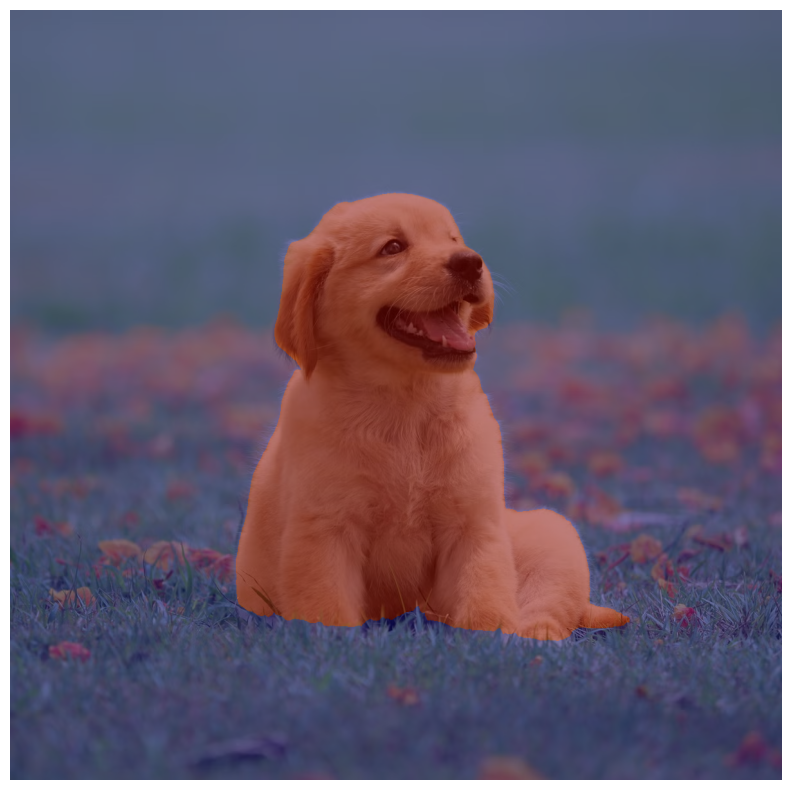

In [ ]:
if len(results[0]["scores"]) == 0:
    raise ValueError("No objects detected for the given prompt. Try a different prompt or lower threshold.")
best_idx = results[0]["scores"].argmax()
best_box = results[0]["boxes"][best_idx].cpu().detach().numpy()  # Detach to fix RuntimeError

input_box = best_box.reshape(1, 4)

with torch.inference_mode(), torch.autocast(device_type=device, dtype=torch.bfloat16):
    predictor.set_image(image_np)
    masks, scores, logits = predictor.predict(
        box=input_box,
        multimask_output=False  # Single mask
    )

mask = masks[0]
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.imshow(mask.astype(np.uint8) * 255, cmap='jet', alpha=0.5)  # Overlay mask with transparency
plt.axis('off')
plt.show()

In [91]:
import cv2 
vid_path="C:/Users/Aditi P/Downloads/assignment/dog.mp4"
cap=cv2.VideoCapture(vid_path)
fps=cap.get(cv2.CAP_PROP_FPS)
fcount=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
dur=fcount/fps
print(dur)


18.933333333333334


In [92]:
frames=[]
while cap.isOpened():
    ret,frame=cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()

print(f"Successfully extracted {len(frames)} frames from video")

Successfully extracted 568 frames from video


In [58]:
if len(frames) < 300 or len(frames) > 900:  # Rough check for 10-30s at 30 FPS
    print("Note: Clip length may affect performance; adjust as needed.")

In [59]:
text_prompt = input("Enter the text prompt for the object to segment (e.g., 'a black car'): ")
texts = [[text_prompt]]

In [83]:
from sam2.build_sam import build_sam2_video_predictor
checkpoint = "./checkpoints/sam2_hiera_small.pt"  # or your checkpoint path
model_cfg = "sam2_hiera_s.yaml"
video_predictor = build_sam2_video_predictor(config_path, checkpoint)

In [84]:
frame0 = Image.fromarray(frames[0])
inputs = owlvit_processor(text=texts, images=frame0, return_tensors="pt").to(device)
outputs = owlvit_model(**inputs)
target_sizes = torch.tensor([frame0.size[::-1]]).to(device)
results = owlvit_processor.post_process_object_detection(
    outputs=outputs, 
    target_sizes=target_sizes, 
    threshold=0.1
)
print("Detection scores:", results[0]["scores"])

Detection scores: tensor([0.2229], device='cuda:0', grad_fn=<IndexBackward0>)


C:\Users\Aditi P\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\owlvit\processing_owlvit.py:221: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


In [ ]:
boxes = results[0]["boxes"]
scores = results[0]["scores"]

if len(boxes) > 0:
    best_idx = torch.argmax(scores)
    best_box = boxes[best_idx].cpu().detach().numpy()  # [x1, y1, x2, y2]
    print(f"Best box: {best_box} with score: {scores[best_idx].item()}")
else:
    raise ValueError("No objects detected in frame 0")

Best box: [ 7.3068070e-01 -5.0783008e-01  4.7448068e+02  8.3555316e+02] with score: 0.22289979457855225


In [ ]:
import tempfile
import shutil
from pathlib import Path

temp_dir = tempfile.mkdtemp()
print(f"Saving frames to temporary directory: {temp_dir}")

for idx, frame in enumerate(frames):
    if isinstance(frame, np.ndarray):
        if frame.dtype != np.uint8:
            frame = (frame * 255).astype(np.uint8) if frame.max() <= 1.0 else frame.astype(np.uint8)
        frame_path = Path(temp_dir) / f"{idx:05d}.jpg"
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(frame_path), frame_bgr)
    else:
        raise TypeError(f"Frame {idx} is not a numpy array")

print(f"Saved {len(frames)} frames")

Saving frames to temporary directory: C:\Users\ADITIP~1\AppData\Local\Temp\tmp8expjpwj
Saved 568 frames


In [ ]:
import gc
if 'frames' in locals() and len(frames) > 0:
    frame0 = Image.fromarray(frames[0])
else:
    video_path = vid_path
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    frame0 = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()

inputs = owlvit_processor(text=texts, images=frame0, return_tensors="pt").to(device)
outputs = owlvit_model(**inputs)
target_sizes = torch.tensor([frame0.size[::-1]]).to(device)
results = owlvit_processor.post_process_object_detection(
    outputs=outputs, 
    target_sizes=target_sizes, 
    threshold=0.1
)
print("Detection scores:", results[0]["scores"])

boxes = results[0]["boxes"]
scores = results[0]["scores"]

if len(boxes) > 0:
    best_idx = torch.argmax(scores)
    best_box = boxes[best_idx].cpu().detach().numpy()
    print(f"Best box: {best_box} with score: {scores[best_idx].item()}")
else:
    raise ValueError("No objects detected")

del inputs, outputs, results
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

C:\Users\Aditi P\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\owlvit\processing_owlvit.py:221: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


Detection scores: tensor([0.2229], device='cuda:0', grad_fn=<IndexBackward0>)
Best box: [ 7.3068070e-01 -5.0783008e-01  4.7448068e+02  8.3555316e+02] with score: 0.22289979457855225
